## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(livetime)
print(parameter_names)

2.154434690031884
[['amplitude', 'index'], ['amplitude', 'lambda_'], ['lambda_', 'index']]


In [4]:
%%time
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 6.24 s, sys: 213 ms, total: 6.45 s
Wall time: 6.47 s


## Datasets

In [5]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
if sys == "Eff_area":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)


In [6]:
        
numpoints = "50_10"

In [7]:
      
def read_in_contour(note):
    results = []
    for parname1, parname2 in parameter_names :
        with open(f"../{c['folder']}/data/3_contour_{note}_{parname1}_{parname2}_{numpoints}.yml", "r") as stream:
            contour = yaml.safe_load(stream)
        results.append(contour)
    return results

In [8]:
%%time
results = read_in_contour("2.15h")
path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
dataset_asimov.models = Models.read(path)
results_N = read_in_contour("N_2.15h")
path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        
    


FileNotFoundError: [Errno 2] No such file or directory: '../Combined_PKSflare_crab_cutoff/data/3_contour_2.15h_amplitude_index_50_10.yml'

NameError: name 'results' is not defined

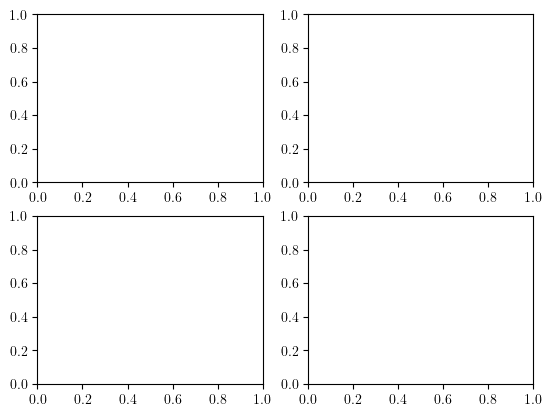

In [9]:
fig,axs = plt.subplots(2,2)
#axs = axs.flatten()
axs = [axs[1][0], axs[0][0], axs[1][1], axs[0][1]]
for i,p in enumerate(parameter_names):
    a = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
    b = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
    axs[i].plot(a, b, color = awo[0])
    axs[i].errorbar(x = dataset_asimov.models[0].parameters[p[0]].value,
                    y = dataset_asimov.models[0].parameters[p[1]].value,
                    xerr = dataset_asimov.models[0].parameters[p[0]].error,
                    yerr = dataset_asimov.models[0].parameters[p[1]].error,
                    color = awo[0],
                    capsize = 6,
                    label = "fit w/o systematic"
                    
                   )
    
    a = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
    b = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
    axs[i].plot(a, b, color = aw[0])
    axs[i].errorbar(x = dataset_asimov_N.models[0].parameters[p[0]].value,
                    y = dataset_asimov_N.models[0].parameters[p[1]].value,
                    xerr = dataset_asimov_N.models[0].parameters[p[0]].error,
                    yerr = dataset_asimov_N.models[0].parameters[p[1]].error,
                    color = aw[0],
                    capsize = 6,
                    label = "fit with systematic"
                   )
    axs[i].errorbar(x = dataset_input.models[0].parameters[p[0]].value,
                    y = dataset_input.models[0].parameters[p[1]].value,
                    color = 'black',
                    marker = 'v',
                    capsize = 6,
                    label = "input"
                   )
    axs[i].set_xlabel(p[0])
    axs[i].set_ylabel(p[1])  
plt.tight_layout()
axs[-1].axis('off')
plt.savefig(f"../{c['folder']}/plots/3_contours.pdf")

### RNDs

In [ ]:
def read_contour_rnd(note):
    i = 0
    results = []
    for parname1, parname2 in parameter_names :
        import yaml
        with open(f"{path}/data/contours/{note}_{parname1}_{parname2}.yml", "r") as stream:
            result = yaml.safe_load(stream)
        results.append(result)
    return results

In [ ]:
pars_N = np.loadtxt(f"../{c['folder']}/data/contours/1_N_P_draw_par.txt")
pars = np.loadtxt(f"../{c['folder']}/data/contours/1_P_draw_par.txt")
N_max = 1000

lives = pars_N[:N_max, -1:]

#mask = [lives.ravel() == livetime]


infos = np.loadtxt(f"../{c['folder']}/data/contours/1_P_draw_info.txt")
shift_rnds = infos[:N_max, 0]#[mask]
index_rnds = infos[:N_max, 1]#[mask]
res_rnds = infos[:N_max, 2]#[mask]
bias_rnds = infos[:N_max, 3]#[mask]

results_rnds, results_rnds_N = [], []
path = f'../{folder}'
for i in range(len(shift_rnds)):
    s = shift_rnds[i]
    t = index_rnds[i]
    r = res_rnds[i]
    b = bias_rnds[i]
    rnds = f"{s:.6}_{t:.6}_{r:.6}_{b:.6}"
    l = lives[i][0]
    if l == livetime:
        try:
            results_rnds.append(read_contour_rnd(rnds))
            results_rnds_N.append(read_contour_rnd( "N"+rnds))
        except:
            i = 0
        
parameters =  ['amplitude', 'index', 'lambda_']
par_values_N = dict()
par_values = dict()
for p in parameters:
    par_values_N[p] = []
    par_values[p] = []

for j in range(len(pars_N)):
    for i in range(len(parameters)):
        p = pars_N[j][i*2: i*2+1]
        par_values_N[parameters[i]].append(p)
        p = pars[j][i*2: i*2+1]
        par_values[parameters[i]].append(p)


In [ ]:
from scipy.interpolate import interp1d

def remove_duplicates(a, b):
    filtered_a = []
    filtered_b = []
    unique_values = {}
    for x, y in zip(a, b):
        if x not in unique_values:
            unique_values[x] = y
            filtered_a.append(x)
            filtered_b.append(y)
    return filtered_a, filtered_b

def interpolate(one, two):
    one, two =  rearange(one,two)
    one, two =  remove_duplicates(one,two)
    
    points = np.column_stack((one, two))  # a (nbre_points x nbre_dim) array
    

    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Interpolation for different methods: #quadratic
    interpolations_methods = ['quadratic']
    alpha = np.linspace(0, 1, 75)

    interpolated_points = {}
    for method in interpolations_methods:
        interpolator =  interp1d(distance, points, kind=method, axis=0)
        interpolated_points[method] = interpolator(alpha)
        
    for method_name, curve in interpolated_points.items():
        c_int = {'x':curve.T[0], 'y': curve.T[1]}
        
    a,b = list(c_int['x']), list(c_int['y'])
    a.append(a[0])
    b.append(b[0])
    return a,b


def rearange(a,b):
    centroid = (sum(a) / len(a), sum(b) / len(b))

    def angle_from_centroid(x, y):
        return np.arctan2(y - centroid[1], x - centroid[0])

    contour_points = [(x, y) for x, y in zip(a, b)]
    contour_points.sort(key=lambda point: angle_from_centroid(point[0], point[1]))

    if np.cross(np.array(contour_points[1]) - np.array(contour_points[0]), 
                np.array(contour_points[-1]) - np.array(contour_points[0])) < 0:
        contour_points.reverse()
        
    #contour_points.append(contour_points[0])
    a, b = zip(*contour_points)
    return a,b

In [ ]:
from scipy.interpolate import interp1d
def interpolate(one, two):
    
    points = np.column_stack((one, two))  # a (nbre_points x nbre_dim) array
    

    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Interpolation for different methods: #quadratic
    interpolations_methods = ['quadratic']
    alpha = np.linspace(0, 1, 75)

    interpolated_points = {}
    for method in interpolations_methods:
        interpolator =  interp1d(distance, points, kind=method, axis=0)
        interpolated_points[method] = interpolator(alpha)
        
    for method_name, curve in interpolated_points.items():
        c_int = {'x':curve.T[0], 'y': curve.T[1]}
    return np.array(c_int['x']), np.array(c_int['y'])

import matplotlib.path as mpltPath
def containing_input(one, two, p):
    pars0 = dataset_input.models.parameters[p[0]]
    pars1 = dataset_input.models.parameters[p[1]]
    path = mpltPath.Path(np.column_stack((one, two)))
    mask = path.contains_points(points = ([(pars0.value, pars1.value)]))
    return mask[0]



In [ ]:
alpha = 0.002
alpha_con= 0.8
def plot_results(results, axs, color):
    cs = []
    for i,p in enumerate(parameter_names):
        a = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
        b = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
        interpolating = True
        if interpolating:
            a,b  = interpolate(a, b)
        #axs[i].plot(a, b, color = awo[0])
        c= containing_input(a,b, p)
        axs[i].plot(a,b, color = color, alpha =alpha_con)
        cs.append(c)
    return cs
    
fig,axs = plt.subplots(2,2)
axs = [axs[1][0], axs[0][0], axs[1][1], axs[0][1]]
for i,p in enumerate(parameter_names):
    a = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
    b = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
    axs[i].plot(a, b, color = awo[0])
    a = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
    b = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
    axs[i].plot(a, b, color = aw[0])
    axs[i].errorbar(x = dataset_input.models[0].parameters[p[0]].value,
                    y = dataset_input.models[0].parameters[p[1]].value,
                    color = 'black',
                    marker = 'v',
                    capsize = 6,
                    label = "input"
                   )
    axs[i].errorbar(x = dataset_asimov.models[0].parameters[p[0]].value,
                        y = dataset_asimov.models[0].parameters[p[1]].value,
                        xerr = dataset_asimov.models[0].parameters[p[0]].error,
                        yerr = dataset_asimov.models[0].parameters[p[1]].error,
                        color = awo[0],
                        capsize = 6,
                        label = "fit w/o systematic"
                       )
    axs[i].errorbar(x = dataset_asimov_N.models[0].parameters[p[0]].value,
                        y = dataset_asimov_N.models[0].parameters[p[1]].value,
                        xerr = dataset_asimov_N.models[0].parameters[p[0]].error,
                        yerr = dataset_asimov_N.models[0].parameters[p[1]].error,
                        color = aw[0],
                        capsize = 6,
                        label = "fit with systematic"
                       )
    axs[i].scatter(par_values[p[0]], par_values[p[1]],marker =  'x', alpha = alpha, color = awo[0])
    axs[i].scatter(par_values_N[p[0]], par_values_N[p[1]],marker =  'o', alpha = alpha, color = aw[0])

wihtin = dict()
wihtin_N = dict()
cases = ['one', 'two', 'three']
for case in cases:
    wihtin[case] = []
    wihtin_N[case] = []

    
for i in range(len(results_rnds)):
    r = results_rnds[i]
    r_N = results_rnds_N[i]
    
    cs = plot_results(r, axs, color = ewo[0])
    cs_N = plot_results(r_N, axs, color = ew[0])
    for i, c_ in enumerate( cases):
        wihtin[c_].append(cs[i])
        wihtin_N[c_].append(cs_N[i])
        
sig = 4
for i,p_ in enumerate(parameter_names):
    p = dataset_asimov.models[0].parameters[p_[1]]
    axs[i].set_ylim(p.value-sig * p.error , p.value+sig * p.error , )
    axs[i].set_ylabel(p.name)
    p = dataset_asimov.models[0].parameters[p_[0]]
    axs[i].set_xlim(p.value-sig * p.error , p.value+sig * p.error , )
    axs[i].set_xlabel(p.name)
    
    
plt.tight_layout()

In [ ]:
print(len(wihtin[case]))
for i, case in enumerate(cases):
    print(case, parameter_names[i])
    print(f"w/o: {np.count_nonzero(wihtin[case]) / len(wihtin[case]) }   ")
    print(f"with: {np.count_nonzero(wihtin_N[case]) / len(wihtin_N[case]) }   ")    

In [ ]:
print(len(wihtin[case]))
for i, case in enumerate(cases):
    print(case, parameter_names[i])
    print(f"w/o: {np.count_nonzero(wihtin[case]) / len(wihtin[case]) }   ")
    print(f"with: {np.count_nonzero(wihtin_N[case]) / len(wihtin_N[case]) }   ")    